# Actividad Académica Dirigida - PSO

# Base

## Clases

In [93]:
class particle:
    '''
    Contiene los parametros de una particula
    '''
    def __init__(self):
        '''
        Inicializador de  la clase
        '''
        self.position = np.array([0,0]) # Almacena la posicion de cada particula
        self.gradient = np.array([0,0]) # Almacena la direccion del graciente de cada particula. v_0 representa el moviemiento en 'x' y v_1 el moviemiento en 'y'
        self.best_position = np.array([]) # Almacena la localizacion de la mejor solucion encontrada por la particula hasta el momento
        self.fitness = None # Almacena el ultimo fitness calculado
        self.best_fitness = None # Almacena el mejor fitness encontrado por la particula

In [94]:
class space_limit:
    
    def __init__(self, *args):
        """
        Constructor de la clase. La clase tiene un contructor por defecto y otro sobrecarcado de 4 parametros.
        El segundo tiene los siguientes parametros:
            x_min : int
                Valor de x minimo
            y_min : int
                Valor de y minimo
            x_max : int
                Valor de x maximo
            y_max : int
                Valor de y maximo
        """
        if len(args) == 4:
            self.x_min = args[0]
            self.y_min = args[1]
            self.x_max = args[2]
            self.y_max = args[3]
        elif len(args) == 0:
            self.x_min = 0
            self.y_min = 0
            self.x_max = 0
            self.y_max = 0
        else:
            raise Exception('Se esperan 4 parametros o ninguno')

## Funciones básicas

In [95]:
import os
import numpy as np

def tsp_to_matrix(path):
    """
    Transforma un fichero .tsp en una matriz de dos dimensiones en el que cada entrada son las coordenadas 'x' e 'y' de cada ciudad
    
    Parametros
        path : str
            Dirección del archivo en disco
    
    Return 
        Devuelve una matriz de floats. Ejemplo:
            Matriz:
                1 - [1.13][5.45]
                2 - [6.51][8.23]
                3 - [85.23][43.34]
                ...
                n - [x][y]
    """
    # Comprobamos que exista el fichero
    if os.path.isfile(path):

        # Convertimos los datos en un matriz de dos dimensiones. Donde cada entrada 
        # es la posicion de una ciudad, columna 0 es la 'x' y la columna 1 la 'y'
        with open(path) as f:
            data = f.readlines()

        # Las 5 primeras lineas de los datos se pueden descartar. Y la ultima tambien
        size_data = len(data)
        data = data[6:size_data-1]
        matrix = np.array([])
        for line in data:
            # Dividimos la linea por espacios y seleccionamos las elementos 1 y 2
            aux = line.split(' ')
            pos = np.array([float(aux[1]), float(aux[2])])

            if len(matrix) != 0:
                matrix = np.append(matrix, [pos], axis=0)
            else:
                matrix = np.array([pos])

        return matrix
    else:
        raise Exception("The file it doesn't exist")

In [96]:
def rosenbrok_function(x,y):
    """
    Funcion Rosenbrok
    
    Parametros 
        x : float
            Valor
        y : float
            Valor
    
    Return 
        Devuelve un valor float
    """
    return (1 - x)**2 + 100*((y - x**2)**2)

In [97]:
import numpy as np
import math
def rastrigin_function(x,y):
    """
    Funcion Rastrigin
    
    Parametros 
        x : float
            Valor
        y : float
            Valor
    
    Return 
        Devuelve un valor float
    """
    return 20 + x**2 + y**2 - 10*(np.cos(2*math.pi*x) + np.cos(2*math.pi*y))

In [98]:
def evaluate(p, function_name):
    """
    Calcula el fitness de una particula en su posicion actual. La funcion de fitness debera ser especificada
    
    Parametros
        p : particle
            Objeto particula
        function_name : str
            Nombre de la funcion de evalucion a emplear. Posibles valores: ['rosenbrok','rastrigin']
            
    Return
        No devuelve nada, el valor es almacenado en el objeto particula. En su variable fitness  
    """
    names = ['rosenbrok','rastrigin'] # Posibles tipos de funcion de coste
    
    if function_name == names[0]: # Rosenbrok
        p.fitness = rosenbrok_function(p.position[0], p.position[1])
        
    elif function_name == names[1]: # Rastrigin
        p.fitness = rastrigin_function(p.position[0], p.position[1])

    else:
        raise Exception(f"No valid function_name. Choose: {names}")

In [99]:
def copy_particle(p):
    """
    Copia una particula
    
    Parametros
        p : particle
            Objeto particula a copiar
    
    Return
        Devuelve un nuevo objeto particula
    """
    new_p = particle()
    new_p.position = p.position.copy()
    new_p.gradient = p.gradient.copy()
    new_p.best_position = p.best_position.copy()
    new_p.fitness = p.fitness
    new_p.best_fitness = p.best_fitness
            
    return new_p

# Algoritmos

## Local PSO

In [195]:
def local_pso(seed, function_name, limits, display):
    """
    Estudia el comportamiento de una funcion usando un algoritmo pso local
    
    Parametros
        seed : int
            Semilla con la que generar numeros
        function_name : str
            Nombre de la funcion de evalucion a emplear. Posibles valores: ['rosenbrok','rastrigin']
        limits : space_limits
            Define el espacio x e y a explorar en la funcion
        display : bool
            Si es igual a 'True' mostrara por pantalla todas las soluciones que vaya encontrando. Dejar a 'False' para no mostrar nada
            
    Return
        Devuelve una lista con los siguientes valores: [best_position, best_fitness, evaluaciones, historial de particulas, numero de rebotes]
    """
    np.random.seed(seed) 

    # CONSTANTES    
    w = 0.729 # Parametro que representa la inercia
    phi_1 = 1.49445 # Ratio de aprendizaje cognitivo (el aprendizaje local, solo la particula en cuestion)
    phi_2 = 1.49445 # Ratio de aprendizaje social (el aprendizaje global, entre todas las particulas)
    
    v_min = -1.0 # minima
    v_max = 1.0 # Velocidad maxima
    
    # VARIABLES
    global_best = None
    global_best_fitness = float('inf')
    history = np.array([]) # Cada entrada tendra la siguiente estructura: [x,y,fitness]
    ev = 0
    n_bounces = 0 # Numero de veces que se ha corregido la trayectoria de una particula
    
    # CREAMOS UNA LISTA DE PARTICULAS
    size = 10
    particles_list = []
    for i in range(0,size):
        particles_list.append(particle())

    # INICIALIZAMOS LAS PARTICULAS
    for p in particles_list:
        # Inicializamos la posicion
        p.position[0] = np.random.uniform(limits.x_min, limits.x_max) # Genera un numero float aleatorio en el intervalo x_min y x_max
        p.position[1] = np.random.uniform(limits.y_min, limits.y_max) # Genera un numero float aleatorio en el intervalo y_min y y_max
        
        # Inicializamos la velocidad
        p.gradient = np.random.uniform(v_min, v_max, 2) # Genera dos numero floats aleatorio en el intervalo v_min y v_max
        
        
    # CONDICION PARA TERMINAR EL BUCLE
    move = 0
    moves_max = 1000
    
    global_min_fitness = 0.001
    
    time_max = 300 # 300s = 5min
    time_start = time.time() # Tiempo maximo
    t = time.time() - time_start # Tiempo actual
    while move < moves_max and t < time_max and global_best_fitness > global_min_fitness:
        
        # EVALUAMOS CADA PARTICULA
        for p in particles_list:
            # Calculamos el fitness asociado a la posicion y lo guardamos en el historial
            evaluate(p, function_name)
            ev += 1
            
            if len(history) != 0:
                history = np.append(history, [[p.position[0], p.position[1], p.fitness]], axis=0) 
            else:
                history = np.array([[p.position[0], p.position[1], p.fitness]])
                
            # Comprobamos si el fitness calculado es mejor el mejor encontrado
            if type(p.best_fitness) != type(None): # Comprobamos que se haya asignado previamente un mejor fitness en la particula
                # Si el fitness calculado es mejor que el mejor encontrado actualizamos
                if p.fitness < p.best_fitness:
                    p.best_fitness = p.fitness
                    p.best_position = p.position.copy()
            else:
                # Inicializamos por primera vez el mejor fitness encontrado por la particula
                p.best_fitness = p.fitness
                p.best_position = p.position.copy()
              
            
            # EL TROZO DE CODIGO SIGUIENTE ES PARA SABER SI HEMOS LLEGADO AL MINIMO, PERO NO FORMA PARTE DEL ALGORITMO COMO TAL
            # Comprobamos si el fitness calculado es mejor que el mejor global
            if p.fitness < global_best_fitness:
                global_best_fitness = p.fitness
                global_best = p.position.copy()
            if display == True:
                print(f"Local PSO new solution | Position: {global_best} - Fitness: [{global_best_fitness}]")

        # ACTUALIZAMOS EL ESTADO DE CADA PARTICULA
        for p in particles_list:
            local_best = circular_social_neighbourhood_lbest(particles_list.index(p), particles_list, 2) # Seleccionamos el mejor fitness encontrado por un vecino
            calculate_gradient(p, local_best, w, phi_1, phi_2) # Calculamos el nuevo gradiente
            calculate_position(p) # Calculamos la nueva posicion de la particula
            n_bounces = n_bounces + check_position(p, limits) # Comprobamos que la posicion de la particula sea valida
            
        move += 1
        t = time.time() - time_start # Tiempo actual
    
    # ORDENAMOS LA LISTA DE PARTICULAS EN FUNCION DEL MEJOR FITNESS ENCONTRADO POR CADA UNA DE ELLAS
    particles_list.sort(key=lambda x: x.best_fitness) # Nos permite ordenar la lista de particulas usando una funcion lambda
    # lambda x: x.best_fitness -> Cogemos un objeto x y de ese objeto cogemos el atributo best_fitness. Este atributo se usara para ordenar en la funcion sort
    
    return [particles_list[0].best_position, particles_list[0].best_fitness, ev, history, n_bounces]

### Metodos auxiliares Local PSO

In [101]:
def gradient_function(pbest, gbest, x, v, w, phi_1, phi_2):
    """
    Funcion del gradiente (velocidad)
    
    Parametros
        pbest : float
            Mejor posicion encontrada por la particula
        gbest : float
            Mejor posicion encontrada por todas las particulas. En el ambito local, gbest pasa a ser lbest. De mejor global a mejor local
        x : float
            Posicion en el eje x. Este valor tambien puede ser un valor en el eje y
        v : float
            Velocidad actual en el eje x. Esta valor tambien puede ser la velocidad en el eje y
        w : float
            Inercia de la particula
        phi_1 : float
            Factor de aprendizaje de la particula
        phi_2 : float
            Factor de aprendizaje global
            
    Return
        Devuelve la nueva velocidad calculada
    """
    return w*v + phi_1*np.random.rand()*(pbest - x) + phi_2*np.random.rand()*(gbest - x)

In [102]:
def calculate_gradient(p, gbest, w, phi_1, phi_2):
    """
    Calcula el gradiente de la particula (velocidad) en funcion de la mejor posicion encontrada por la misma y la mejor posicion
    encontrada en el ambito local. En el gradiente local, pBest y lBest son iguales
    
    Parametros
        p : particle
            Objeto particula
        gbest : ndarray
            Mejor posicion encontrada por todas las particulas. En el ambito local, gbest pasa a ser lbest. De mejor global a mejor local.
            Es un array con dos valores: [x,y]
        w : float
            Inercia de la particula
        phi_1 : float
            Factor de aprendizaje de la particula
        phi_2 : float
            Factor de aprendizaje global
    
    Return 
        No devuelve nada, actualizar la lista gradiente (velocidad) en la particula pasada por parametro
    """
    p.gradient[0] = gradient_function(p.best_position[0], gbest[0], p.position[0], p.gradient[0], w, phi_1, phi_2)
    p.gradient[1] = gradient_function(p.best_position[1], gbest[1], p.position[1], p.gradient[1], w, phi_1, phi_2)
    

In [103]:
def calculate_position(p):
    """
    Calcula la posicion de una particula en funcion de su posicion y su velocidad
    
    Parametros
        p : particle
            Objeto particula
            
    Return
        No devuelve nada, actualiza la posicion de la particula
    """
    p.position = p.position + p.gradient
    

In [104]:
def check_position(p, limits):
    """
    Comprueba que la posicion de la particula sea valida
    
    Parametros
        p : particle
            Objeto particula
        limits : space_limit
            Objeto de tipo space_limit
    Return 
        Devuelve el numero de veces que se ha correguido la trayectoria
    """
    bounce = 0 # Numero de veces que hemos corregido la trayectoria
    
    # COMPROBAMOS EN EL EJE X
    if p.position[0] > limits.x_max:
        p.position[0] = limits.x_max - p.position[0] # Lo volvemos a meter en el plano
        p.gradient[0] = p.gradient[0] * -1 # Le establecemos la velocidad en negativo para que vaya hacia atras (efecto de robote)
        bounce += 1
        
    if p.position[0] < limits.x_min:
        p.position[0] = limits.x_min + p.position[0]
        p.gradient[0] = p.gradient[0] * -1 # Cambiamos de velocidad negativa a positiva
        bounce += 1
        
    # COMPROBAMOS EN EL EJE Y
    if p.position[1] > limits.y_max:
        p.position[1] = limits.y_max - p.position[1]
        p.gradient[1] = p.gradient[1] * -1 # Cambiamos de velocidad positiva a negativa
        bounce += 1
        
    if p.position[1] < limits.y_min:
        p.position[1] = limits.y_min + p.position[1]
        p.gradient[1] = p.gradient[1] * -1 # Cambiamos de velocidad negativa a postiva
        bounce += 1
    
    return bounce

In [105]:
def circular_social_neighbourhood_lbest(index, particles_list, vecindad):
    """
    Consigue la mejor posicion en el ambito local de la particula
    
    Parametros
        index : int
            Posicion en la lista de la particula sobre la cual mirar su vecinos
        particles_list : list
            Lista de particulas
        vecindad : int
            Numero de vecinos a seleccionar a izquierda y derecha de la particula indicada en index
    
    Return 
        Devuelve la mejor posicion encontrada por las particulas locales
    """
    
    size_list = len(particles_list)
    
    # COMPROBAMOS QUE PODEMOS COGER EL LADO DERECHO
    right = None
    p = size_list - (index + 1) # Mas uno porque tenemos que coger los dos vecinos colindantes al index
    if p < vecindad: # Comprobamos si al coger la parte derecha nos pasamos
        aux = particles_list[(index+1):] # Selecionamos todas las particulas hasta el final del array
        number = vecindad - p # Numero de particulas a coger desde el inicio del array (las que faltan para tener la vecindad)
        right = aux + particles_list[:number] 
        
    else:
        right = particles_list[(index+1):(index+1+vecindad)]
        
        
    # COMPROBAMOS QUE PODEMOS COGER EL LADO IZQUIERDO
    left = None
    p = index - vecindad # No le ponemos menos uno porque debemos contar con el 0 
    if p < 0:
        aux = particles_list[:index]
        number = size_list + p # Al ser p negativo, basta con sumar p con el tamanio del array para obtener la posicion de la particula a seleccionar
        left = particles_list[number:] + aux
    else:
        left = particles_list[(index-vecindad):(index)]
        
    # CREAMOS EL VECINDARIO
    neighbourhood = left + right
    
    # CONSEGUIMOS EL MEJOR FITNESS DE ENTRE LOS VECINOS
    lbest = np.array([])
    lbest_fitness = float('inf')
    for neighbour in neighbourhood:
        if neighbour.best_fitness < lbest_fitness:
            lbest = neighbour.best_position.copy()
            lbest_fitness = neighbour.best_fitness
    
    return lbest

## Global PSO

In [196]:
def global_pso(seed, function_name, limits, display):
    """
    Estudio el comportamiento de una funcion usando un algoritmo pso local
    
    Parametros
        seed : int
            Semilla con la que generar numeros
        function_name : str
            Nombre de la funcion de evalucion a emplear. Posibles valores: ['rosenbrok','rastrigin']
        limits : space_limits
            Define el espacio x e y a explorar en la funcion
        display : bool
            Si es igual a 'True' mostrara por pantalla todas las soluciones que vaya encontrando. Dejar a 'False' para no mostrar nada
    Return
        Devuelve una lista con los siguientes valores: [best_position, best_fitness, evaluaciones, historial de particulas, numero de rebotes]
    """
    np.random.seed(seed) 

    # CONSTANTES    
    w = 0.729 # Parametro que representa la inercia
    phi_1 = 1.49445 # Ratio de aprendizaje cognitivo (el aprendizaje local, solo la particula en cuestion)
    phi_2 = 1.49445 # Ratio de aprendizaje social (el aprendizaje global, entre todas las particulas)
    
    v_min = -1.0 # Velocidad minima
    v_max = 1.0 # Velocidad maxima
    
    # VARIABLES
    history = np.array([]) # Cada entrada tendra la siguiente estructura: [x,y,fitness]
    ev = 0
    global_best = np.array([])
    global_best_fitness = float('inf')
    n_bounces = 0
    
    # CREAMOS UNA LISTA DE PARTICULAS
    size = 10
    particles_list = []
    for i in range(0,size):
        particles_list.append(particle())

    # INICIALIZAMOS LAS PARTICULAS
    for p in particles_list:
        # Inicializamos la posicion
        p.position[0] = np.random.uniform(limits.x_min, limits.x_max) # Genera un numero float aleatorio en el intervalo x_min y x_max
        p.position[1] = np.random.uniform(limits.y_min, limits.y_max) # Genera un numero float aleatorio en el intervalo y_min y y_max
        
        # Inicializamos la velocidad
        p.gradient = np.random.uniform(v_min, v_max, 2) # Genera dos numero floats aleatorio en el intervalo v_min y v_max
        
        
    # CONDICION PARA TERMINAR EL BUCLE
    move = 0
    moves_max = 1000
    
    global_min_fitness = 0.001
    
    time_max = 300 # 300s = 5min
    time_start = time.time() # Tiempo maximo
    t = time.time() - time_start # Tiempo actual
    while move < moves_max and t < time_max and global_best_fitness > global_min_fitness:
        
        # EVALUAMOS CADA PARTICULA
        for p in particles_list:
            # Calculamos el fitness asociado a la posicion y lo guardamos en el historial
            evaluate(p, function_name)
            ev += 1
            
            if len(history) != 0:
                history = np.append(history, [[p.position[0], p.position[1], p.fitness]], axis=0) 
            else:
                history = np.array([[p.position[0], p.position[1], p.fitness]])
                
            # Comprobamos si el nuevo fitness calculado es mejor al mejor encontrado por la particula
            if type(p.best_fitness) != type(None): # Comprobamos que se haya asignado previamente un mejor fitness en la particula
                # Si el fitness calculado es mejor que el mejor encontrado previamente encontrado por la particula actualizamos
                if p.fitness < p.best_fitness:
                    p.best_fitness = p.fitness
                    p.best_position = p.position.copy()
                    
            else:
                # Inicializamos por primera vez el mejor fitness encontrado por la particula
                p.best_fitness = p.fitness
                p.best_position = p.position.copy()
                
            # Comprobamos si el fitness calculado es mejor que el mejor global
            if p.fitness < global_best_fitness:
                global_best_fitness = p.fitness
                global_best = p.position.copy()
                if display == True:
                    print(f"Global PSO new solution | Position: {global_best} - Fitness: [{global_best_fitness}]")
            
        # ACTUALIZAMOS EL ESTADO DE CADA PARTICULA
        for p in particles_list:
            calculate_gradient(p, global_best, w, phi_1, phi_2) # Calculamos el nuevo gradiente
            calculate_position(p) # Calculamos la nueva posicion de la particula
            n_bounces = n_bounces + check_position(p, limits) # Comprobamos que la posicion de la particula sea valida
            
        move += 1
        t = time.time() - time_start # Tiempo actual
    
    return [global_best, global_best_fitness, ev, history, n_bounces]

## Local Search

In [107]:
def local_search(seed, function_name, limits, display):
    """
    Estudia el comportamiento de una funcion usando un algoritmo de busqueda local
    
    Parametros
        seed : int
            Semilla con la que generar numeros
        function_name : str
            Nombre de la funcion de evalucion a emplear. Posibles valores: ['rosenbrok','rastrigin']
        display : bool
            Si es igual a 'True' mostrara por pantalla todas las soluciones que vaya encontrando. Dejar a 'False' para no mostrar nada
        limits : space_limits
            Define el espacio x e y a explorar en la funcion
    Return
        Devuelve una lista con los siguientes valores: [best_position, best_fitness, evaluaciones, historial de particulas]
    """
    # Inicializamos la semilla
    np.random.seed(seed) 
    ev = 0 # Numero de evaluaciones realizadas
    
    # Historial de resultados
    history = np.array([])
    
    # Creamos nuestra solucion inicial
    init_particle = particle()
    if function_name == 'rosenbrok':
        init_particle.position = np.array([10.0,0.0])
    else:
        init_particle.position = np.array([5.0,5.0])
    evaluate(init_particle, function_name)
    
    history = np.array([[init_particle.position[0], init_particle.position[1], init_particle.fitness]])
    if display == True:
        print(f"LS init solution | Position: {init_particle.position} - Fitness: [{init_particle.fitness}]")
    
    # Inicializamos las variables
    actual_particle = copy_particle(init_particle)
    best_neighbour_particle = None
    neighbour_particle = particle()
    
    # Variables de control
    max_i = 3000 # Numero maximo de intentos a realizar
    i = 0 # Iteracion actual
    best_neighbour_finded = True
    
    # Buscamos mientras no superemos el numero maximo de busquedas (max_calls) y siempre que encontremos una solucion mejor a la actual en la nueva iteracion
    while i < max_i and best_neighbour_finded == True:
        # Guardamos la solucion actual como el mejor vecino encontrado
        best_neighbour_particle = copy_particle(actual_particle)
        
        # Generamos la lista de posiciones vecinas a partir de la posicion actual
        position_list = movement_operator(actual_particle)
        for position in position_list:
            neighbour_particle.position = position # Le asignamos a nuestra particula vecina la posicion de un nuevo vecino
            evaluate(neighbour_particle, function_name) # La solucion se guardada en la variable fitness de la particula
            ev += 1
            
            # Aniadimos el vecino encontrado al historial
            history = np.append(history, [[neighbour_particle.position[0], neighbour_particle.position[1], neighbour_particle.fitness]], axis=0)
            
            # Si el vecino encontrado es mejor que nuestra mejor solucion
            if best_neighbour_particle.fitness > neighbour_particle.fitness:
                best_neighbour_particle = copy_particle(neighbour_particle)
                
        # Comprobamos si la solucion obtenida por el vecino es mejor que nuestra solucion actual
        if best_neighbour_particle.fitness < actual_particle.fitness: 
            # Guardamos al vecino como la nueva solucion actual y seguimos buscando
            actual_particle = copy_particle(best_neighbour_particle)
            if display == True:
                print(f"New LS best solution | Position: {actual_particle.position} - Fitness: [{actual_particle.fitness}]")
                
        else:
            best_neighbour_finded = False
            
        i += 1 # Nueva iteracion
        
       
    return [actual_particle.position, actual_particle.fitness, ev, history]         

### Metodos auxiliares Local Search

In [108]:
def movement_operator(p):
    """
    Devuelve una lista de las posiciones en la que se encuentran los vecinos de la particula p. Devuelve 10 posiciones
    
    Parametros
        p : particle
            Objeto particula del cual se quiere explorar sus vecinos
    
    Return
        Devuelve una lista de posiciones. [[x1,y1],[x2,y2], ... ]
    """
    
    # Variables
    n_neighbours = 10
    variation = 0.1 # Las vecinos estaran a +-0.1 de distancia con respecto la posicion de la particula en cada eje
    positions_list = np.array([])
    
    # DEBEMOS CREAR UNA LISTA DE POSICIONES PARA 10 VECINOS DE p
    for i in range(0,n_neighbours):
        position = np.array([0.0,0.0]) # Inicializamos la posicion
        position[0] = np.random.uniform(p.position[0]-variation, p.position[0]+variation) # Genera un numero float aleatorio en el intervalo x_min y x_max 
        position[1] = np.random.uniform(p.position[1]-variation, p.position[1]+variation) # Genera un numero float aleatorio en el intervalo x_min y x_max 
        
        if len(positions_list) > 0:
            positions_list = np.append(positions_list, [position.copy()], axis=0)
        else:
            positions_list = np.array([position.copy()])
            
    return positions_list

# Test

## Base

In [197]:
names = ['rosenbrok','rastrigin']
seed = 3000

limits = space_limit()
limits.x_min = -10
limits.y_min = -10
limits.x_max = 10
limits.y_max = 10

results_test = np.array([])
ev_test = np.array([])

## Local Search Test

In [198]:
names = ['rosenbrok','rastrigin']
display = False
for name in names:
    position, fitness, ev, history = local_search(seed, name, limits, display)
    print(f"{name} LS best solution | Position: {position} - Fitness: [{fitness}] - Ev: {ev}")
    
    if len(results_test) == 0:
        results_test = np.array([np.append(position,fitness)])
    else:
        results_test = np.append(results_test,[np.append(position,fitness)], axis=0)
        
    if name == names[0]:
        history_ls_rosenbrok = history.copy()
    else:
        history_ls_rastrigin = history.copy()
        
    ev_test = np.append(ev_test, ev)
        

rosenbrok LS best solution | Position: [1.11903584 1.24710014] - Fitness: [0.01681259330502742] - Ev: 1110
rastrigin LS best solution | Position: [4.9673638  4.97815173] - Fitness: [49.7602852646208] - Ev: 20


## Local PSO Test

In [199]:
import time
names = ['rosenbrok','rastrigin']
display = False

for name in names:
    position, fitness, ev, history, n_bounces = local_pso(seed, name, limits, display)
    print(f"{name} Local PSO best solution | Position: {position} - Fitness: [{fitness}] - Ev: {ev} - Bounces: {n_bounces}")
    
    results_test = np.append(results_test, [np.append(position,fitness)], axis=0)
    
    if name == names[0]:
        history_lpso_rosenbrok = history.copy()
    else:
        history_lpso_rastrigin = history.copy()
    
    ev_test = np.append(ev_test, ev)

rosenbrok Local PSO best solution | Position: [0.96945006 0.94053321] - Fitness: [0.0009822697742811958] - Ev: 2430 - Bounces: 1
rastrigin Local PSO best solution | Position: [0 0] - Fitness: [0.0] - Ev: 10 - Bounces: 0


## Global PSO Test

In [200]:
import time
names = ['rosenbrok','rastrigin']
display = False

for name in names:
    position, fitness, ev, history, n_bounces = global_pso(seed, name, limits, display)
    print(f"{name} Global PSO best solution | Position: {position} - Fitness: [{fitness}] - Ev: {ev} - Bounces: {n_bounces}")

    results_test = np.append(results_test, [np.append(position,float(fitness))], axis=0)
    
    if name == names[0]:
        history_gpso_rosenbrok = history.copy()
    else:
        history_gpso_rastrigin = history.copy()
        
    ev_test = np.append(ev_test, ev)

rosenbrok Global PSO best solution | Position: [0.9737369  0.94752989] - Fitness: [0.0007299030931065988] - Ev: 710 - Bounces: 0
rastrigin Global PSO best solution | Position: [0 0] - Fitness: [0.0] - Ev: 10 - Bounces: 0


# Resultados

In [204]:
import pandas as pd
import statistics as st

algorithm = ['Local Search','Local PSO','Global PSO']
columns = ['Rosenbrok cost','Rosenbrok Ev','Rastrigin cost','Rastrigin Ev']
df_columns = [''] + columns # Columnas del DataFrame
df = pd.DataFrame(columns=df_columns) # Dataframe que almacena toda la informacion
rosenbrok_results = []
rastrigin_results = []
ev_rosenbrok = []
ev_rastrigin = []

a = 0 # Para determinar el nombre del algoritmo
i = 0
while i < len(results_test):
    rosenbrok_results = rosenbrok_results + [results_test[i][2]]
    rastrigin_results = rastrigin_results + [results_test[i+1][2]]
    
    ev_rosenbrok = ev_rosenbrok + [ev_test[i]]
    ev_rastrigin = ev_rastrigin + [ev_test[i+1]]
    
    row = [algorithm[a], results_test[i][2], ev_test[i], results_test[i+1][2], ev_test[i+1]]
    df.loc[len(df)] = row
    
    a += 1
    i += 2


ev_rastrigin = np.round(ev_rastrigin)
extra_row = ['Mean','Std']
row = [extra_row[0], st.mean(rosenbrok_results), st.mean(ev_rosenbrok), st.mean(rastrigin_results), st.mean(ev_rastrigin)]
df.loc[len(df)] = row

row = [extra_row[1], st.stdev(rosenbrok_results), st.stdev(ev_rosenbrok), st.stdev(rastrigin_results), st.stdev(ev_rastrigin)]
df.loc[len(df)] = row
        
df = df.set_index(df_columns[0])
df.to_csv('./results/results.csv')
df

,Rosenbrok cost,Rosenbrok Ev,Rastrigin cost,Rastrigin Ev
,,,,
Local Search,0.016813,1110.000000,49.760285,20.000000
Local PSO,0.000982,2430.000000,0.000000,10.000000
Global PSO,0.000730,710.000000,0.000000,10.000000
Mean,0.006175,1416.666667,16.586762,13.333333
Std,0.009213,900.074071,28.729114,5.773503


# Representation

## Representar comparacion de los algoritmos

Local Search - Punto(4.967363799096388, 4.978151728678303, 49.7602852646208)
Local PSO - Punto(0.0, 0.0, 0.0)
Global PSO - Punto(0.0, 0.0, 0.0)


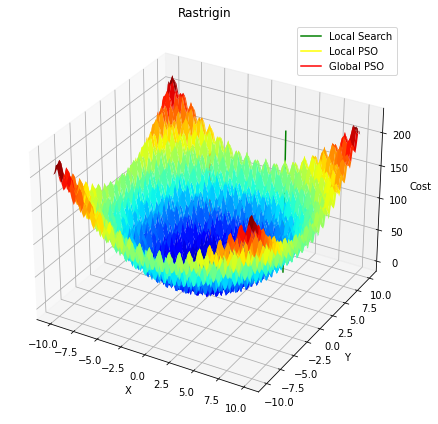

In [178]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Para poder rotar la grafica usamos la siguiente setencia - SOLO EN NOTEBOOK
#%matplotlib notebook


plt.rcParams["figure.autolayout"] = True

fig = plt.figure(figsize=(7,6))
ax.set_facecolor('white')
ax = fig.add_subplot(111, projection='3d')

# REPRESENTAMOS LOS PUNTOS ENCONTRADOS EN EL PLANO
names = ['Rosenbrok','Rastrigin']


legend = ['Local Search','Local PSO','Global PSO']
color = ['green','yellow','red']
marker = ['o','x','p']
size = 120

# Plano de la funcion
x = np.linspace(limits.x_min, limits.x_max, 100)
y = np.linspace(limits.y_min, limits.y_max, 100)
xx, yy = np.meshgrid(x,y) # Convertimos esos valores en una malla. Es decir, convertimoms nuestro array de 1D en otro en 2D

name = names[1]
if name == names[0]:
    zz = rosenbrok_function(xx,yy)
else:
    zz = rastrigin_function(xx,yy)
    
# En funcion de que algoritmo hayamos escogido debemos seleccionar unos valores u otros
# Los de rosenbrok son los impares y los de rastrigin son los pares

lpar = []
limpar = []
for i in range(0,len(results_test)):
    if i%2 == 0:
        lpar = lpar + [i]
    else:
        limpar = limpar + [i]
        
if name != names[0]:
    l = limpar
else:
    l = lpar
    
s = 0
for i in l:
    aux = results_test[i].copy()
    
    # Mostramos por pantalla
    print(f"{legend[s]} - Punto({aux[0]}, {aux[1]}, {aux[2]})")
    
    # Pintamos el punto
    ax.scatter3D(aux[0], aux[1], aux[2], s=size, marker=marker[s], c=color[s])

    # Hacemos una linea de corte
    zmin = np.amin(zz)
    zmax = np.amax(zz)
    xl = np.ones(200) * aux[0]
    yl = np.ones(200) * aux[1]
    zl = np.linspace(zmin,zmax,200)
    ax.plot(xl,yl,zl,c=color[s])
    
    s += 1

# NOMBRE DE LOS EJES
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Cost")

# ESTABLECER MARCADORES EN LOS EJES
#ax.set_xticks([-10.0,-7.5,-5.0,-2.5,0.0,2.5,5.0,7.5,10.0])
#ax.set_yticks([-10.0,-7.5,-5.0,-2.5,0.0,2.5,5.0,7.5,10.0])
#ax.set_zticks(np.linspace(0, 1000, 111))


# DIBUJAR PLANO DE LA FUNCION
cmap = mpl.cm.jet
ax.plot_surface(xx,yy,zz, cmap=cmap, linewidth=0, antialiased=True)

# ESTABLECER LIMITES EN LOS EJES
#ax.set_zlim3d(zmin=0,zmax=1000)
    
plt.legend(legend)
plt.title(name)
#plt.savefig("./img/img.png")
plt.show()

## Representar historial

Numero de soluciones encontradas: 710


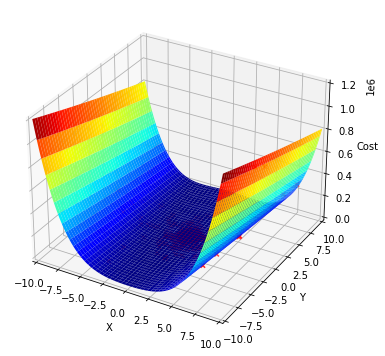

In [203]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Para poder rotar la grafica usamos la siguiente setencia - SOLO EN NOTEBOOK
#%matplotlib notebook

plt.rcParams["figure.autolayout"] = True

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')

# NOMBRE DE LOS EJES
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Cost")

# ESTABLECER MARCADORES EN LOS EJES
#ax.set_xticks([-10.0,-7.5,-5.0,-2.5,0.0,2.5,5.0,7.5,10.0])
#ax.set_yticks([-10.0,-7.5,-5.0,-2.5,0.0,2.5,5.0,7.5,10.0])
#ax.set_zticks([0.2,0.4,0.6,0.8,1.0,1.2])
ax.set_xlim([-10.0,10.0])
ax.set_ylim([-10.0,10.0])


# PLANO DE LA FUNCION
x = np.linspace(limits.x_min, limits.x_max, 100)
y = np.linspace(limits.y_min, limits.y_max, 100)
xx, yy = np.meshgrid(x,y) # Convertimos esos valores en una malla. Es decir, convertimoms nuestro array de 1D en otro en 2D

name = names[0]
if name == names[0]:
    zz = rosenbrok_function(xx,yy)
    ax.set_zlim([0.0,(1.2*1000000)])
else:
    zz = rastrigin_function(xx,yy)
    ax.set_zlim([0.0,200.0])

cmap = mpl.cm.jet
ax.plot_surface(xx,yy,zz, cmap=cmap, linewidth=0, antialiased=True)

# REPRESENTAMOS LOS PUNTOS ENCONTRADOS EN EL PLANO
legend = ['Local Search','Local PSO','Global PSO']
color = ['green','yellow','red','blue']
marker = ['o','x','p']

history = history_gpso_rosenbrok
print(f"Numero de soluciones encontradas: {len(history)}")
x = [item[0] for item in history]
y = [item[1] for item in history]
z = [item[2] for item in history]

ax.scatter3D(x, y, z, s=20,  marker=marker[1], c=color[2])

plt.show()